### Intralaminar

In [1]:
import sys

#sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding")
sys.path.insert(1, "/home/vinicius/Documentos/phase_amplitude_encoding")

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm
from scipy.signal import chirp

from src.models import simulate, simulate_delayed

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
                  # L23e1  L23i1 L56e1 L56i1
W     = np.array([[1.50, -3.25, 0.00, 0.00],  # L23e1
	              [3.50, -2.50, 0.75, 0.00],  # L23i1
	              [1.00, 0.00, 1.50, -3.25],  # L56e1
	              [0.00, 0.00, 3.50, -2.50]])  # L56i1

In [9]:
Nareas = 4
ntrials = 10
fsamp = 1 / 1e-5
time = np.arange(-3, 2, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 200
f = 40

In [10]:
Iext = np.zeros((Nareas, Npoints))
Iext[2, (time >= 0) & (time <= 0.4)] = 1
Amplitudes = np.linspace(0, .1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [11]:
out = []
for trial in tqdm(range(ntrials)):

    out += [
        simulate(
            W,
            1,
            np.array([60, 60, 30, 30]),
            -5,
            fsamp,
            beta,
            Npoints,
            CS[trial] * 0,  
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]

100%|████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/it]


In [12]:
area_names = [
    "V1_23e",
    "V1_23i",
    "V1_5e",
    "V1_5i",
]

data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, area_names, time[::decim]),
).sel(times=slice(-1, 1))

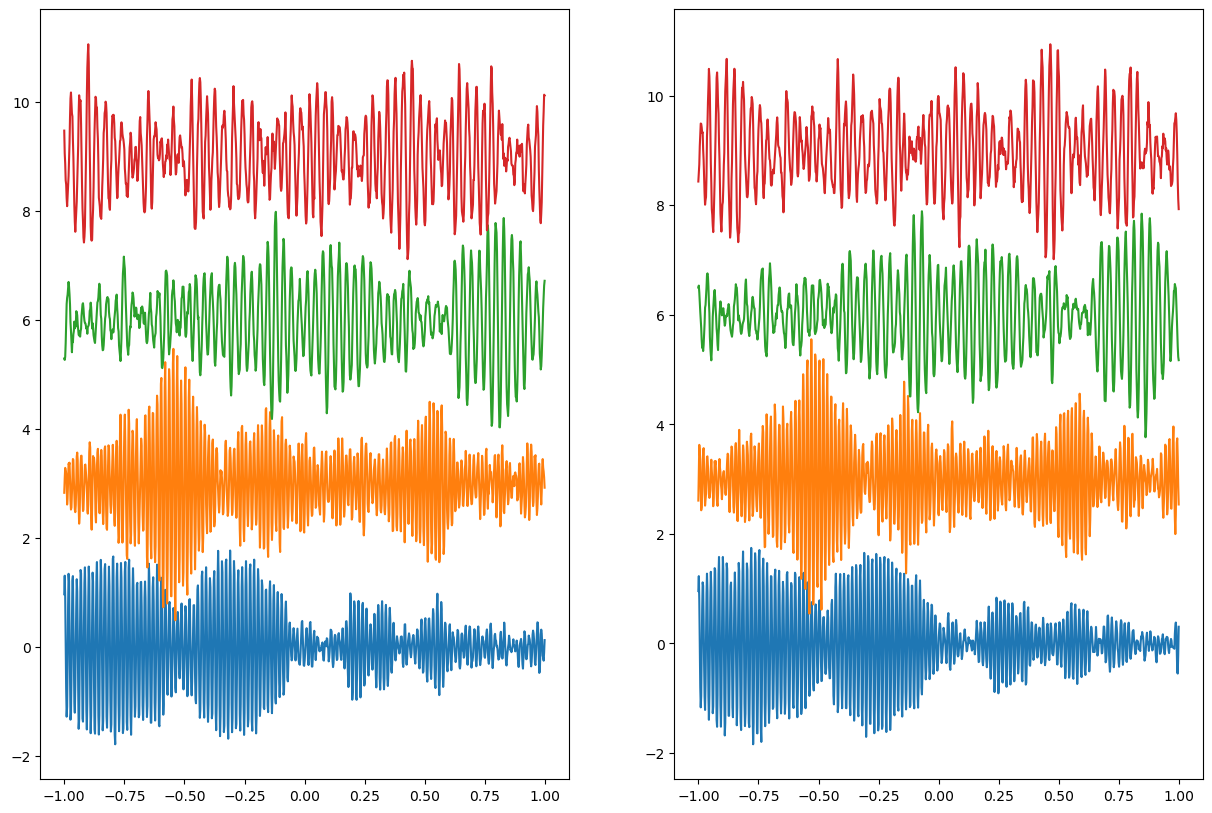

In [13]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

In [14]:
from spectralMI import spectralMI

In [15]:
freqs = np.linspace(0.3, 80, 50)

MI = spectralMI(
    data,
    Amplitudes,
    freqs,
    roi="roi",
    times="times",
    n_cycles=freqs / 7,
    n_jobs=1,
    mode="phase",
)

Defining links (n_roi=4; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise spectral MI (n_pairs=6, n_freqs=50, decim=1)
100%|██████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.01it/s]


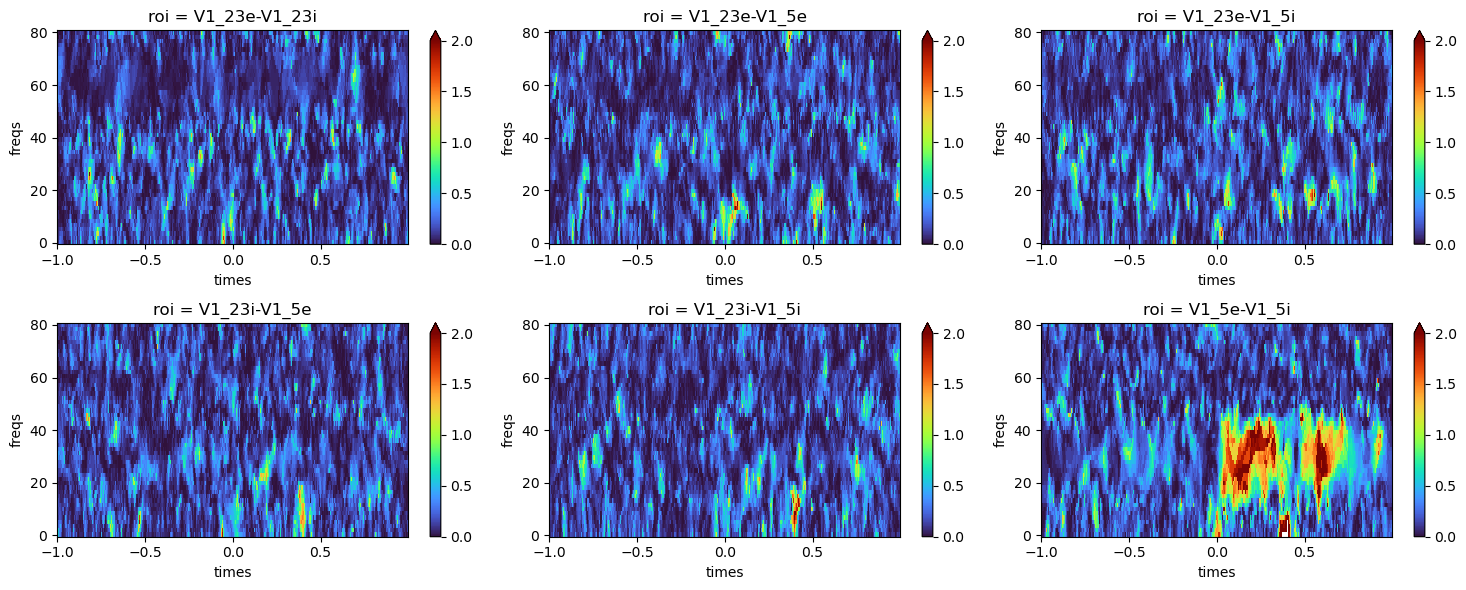

In [11]:
plt.figure(figsize=(15, 6))
pos = 1
for roi in MI.roi.values:
    plt.subplot(2, 3, pos)
    MI.sel(roi=roi).plot(cmap="turbo", vmin=0, vmax=2)
    pos = pos + 1
plt.tight_layout()